In [12]:
"""
==========================================================================
Fusion of three data sources for gene function prediction in Dictyostelium
==========================================================================

Fuse three data sets: gene expression data (Miranda et al., 2013, PLoS One),
slim gene annotations from Gene Ontology and protein-protein interaction
network from STRING database.

Learnt latent matrix factors are utilized for the prediction of slim GO
terms in Dictyostelium genes that are unavailable in the training phase.

This example demonstrates how latent matrices estimated by data fusion
can be utilized for association prediction.
"""
from builtins import enumerate

print(__doc__)

# from sklearn import cross_validation
from sklearn import metrics
from sklearn.model_selection import KFold
import numpy as np

from skfusion import datasets
from skfusion import fusion as skf

import sys
#sys.path.append('/mag/scripts')
sys.path.append('/home/lpodgorsek/mag/scripts')
import utilityFunctions as uf
import base2




dicty = datasets.load_dicty()
gene = dicty.get_object_type("Gene")
go_term = dicty.get_object_type("GO term")
exp_cond = dicty.get_object_type("Experimental condition")

dicty[gene][go_term][0].data = base2.resize_rows_and_columns(dicty[gene][go_term][0].data, 2)
dicty[gene][exp_cond][0].data = base2.resize_rows_and_columns(dicty[gene][exp_cond][0].data, 2)
dicty[gene][gene][0].data = base2.resize_rows_and_columns(dicty[gene][gene][0].data, 2)

dicty[gene][go_term][0].data = uf.normalization(dicty[gene][go_term][0].data)
dicty[gene][exp_cond][0].data = uf.normalization(dicty[gene][exp_cond][0].data)
dicty[gene][gene][0].data = uf.normalization(dicty[gene][gene][0].data)

dicty[gene][go_term][0].data = uf.order_by_clustering(dicty[gene][go_term][0].data, 'single')
dicty[gene][exp_cond][0].data = uf.order_by_clustering(dicty[gene][exp_cond][0].data, 'single')
dicty[gene][gene][0].data = uf.order_by_clustering(dicty[gene][gene][0].data, 'single')

n_folds = 10
n_genes = dicty[gene][go_term][0].data.shape[0]

kfold = KFold(n_splits=n_folds)
fold_mse = np.zeros(n_folds)
ann_mask = np.zeros_like(dicty[gene][go_term][0].data).astype('bool')

relations = [
    skf.Relation(dicty[gene][go_term][0].data, gene, go_term),
    skf.Relation(dicty[gene][exp_cond][0].data, gene, exp_cond),
    skf.Relation(dicty[gene][gene][0].data, gene, gene)]
fusion_graph = skf.FusionGraph(relations)
fuser = skf.Dfmc(max_iter=30, n_run=1, init_type='random', random_state=0)

predict_DFMF = np.empty((0, 128))
data_idx = [x for x in range(n_genes)]
for i, (train_idx, test_idx) in enumerate(kfold.split(data_idx)):
    ann_mask[:] = False
    ann_mask[test_idx, :] = True
    fusion_graph[gene][go_term][0].mask = ann_mask

    fuser.fuse(fusion_graph)
    pred_ann = fuser.complete(fuser.fusion_graph[gene][go_term][0])[test_idx]
    true_ann = dicty[gene][go_term][0].data[test_idx]
    fold_mse[i] = metrics.mean_squared_error(pred_ann, true_ann)
    predict_DFMF = np.r_[predict_DFMF, pred_ann]

print("MSE: %5.4f" % np.mean(fold_mse))


Fusion of three data sources for gene function prediction in Dictyostelium

Fuse three data sets: gene expression data (Miranda et al., 2013, PLoS One),
slim gene annotations from Gene Ontology and protein-protein interaction
network from STRING database.

Learnt latent matrix factors are utilized for the prediction of slim GO
terms in Dictyostelium genes that are unavailable in the training phase.

This example demonstrates how latent matrices estimated by data fusion
can be utilized for association prediction.

MSE: 0.0326


-0.5303144453440359
1.355988836328652


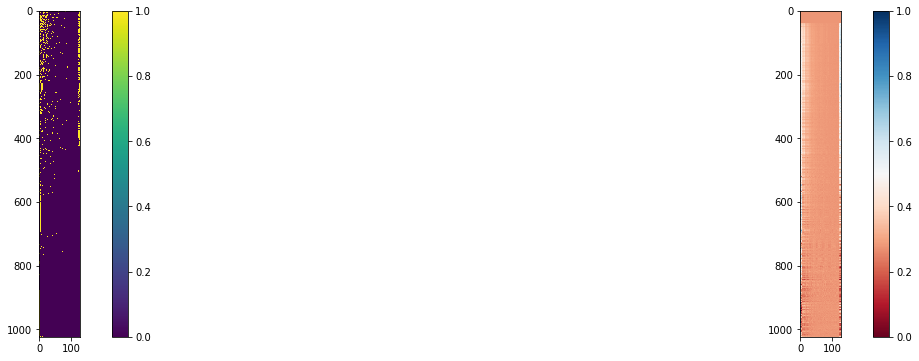

In [27]:
import matplotlib.pyplot as plt
import matplotlib as mpl


org_data = dicty[gene][go_term][0].data
predict = predict_DFMF

color_pack = 'viridis'
color_pack2 = 'RdBu'

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25,6))

print(np.min(predict))
print(np.max(predict))

predict = predict - np.min(predict)
predict = predict / np.max(predict)


ax = axes[0]
im = ax.imshow(org_data, vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack))

ax = axes[1]
im2 = ax.imshow(predict, vmin=np.min(predict), vmax=np.max(predict), cmap=plt.cm.get_cmap(color_pack2))

#     ax = axes[2]
#     im = ax.imshow(predict - org_data, vmin=-1, vmax=1, cmap=plt.cm.get_cmap(color_pack))

# fig.colorbar(im, ax=axes.ravel().tolist())
#     cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
cax,kw = mpl.colorbar.make_axes([axes[0]])
cax2,kw2 = mpl.colorbar.make_axes([axes[1]])
cba = plt.colorbar(im, cax=cax, **kw)
cbb = plt.colorbar(im2, cax=cax2, **kw2)

path= '/home/lpodgorsek/mag/Experiments/Results/13/dicty/'
numOfExperiment = 13
plt.savefig(path + 'experiment' + str(numOfExperiment) + '_' + str(i) + '_org_vs_predict.png')

plt.show()

In [18]:
fig = plt.figure(constrained_layout=True)

import matplotlib.gridspec as gridspec

gs0 = gridspec.GridSpec(1, 2, figure=fig)

gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[0])
for n in range(1):
    ax = fig.add_subplot(org_data)
    example_plot(ax)


gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[1])
for n in range(1):
    ax = fig.add_subplot(predict)
    example_plot(ax)

plt.show()

TypeError: unhashable type: 'numpy.ndarray'

<Figure size 432x288 with 0 Axes>

0.0
0.0
1.0
1.0
0.0
1.0


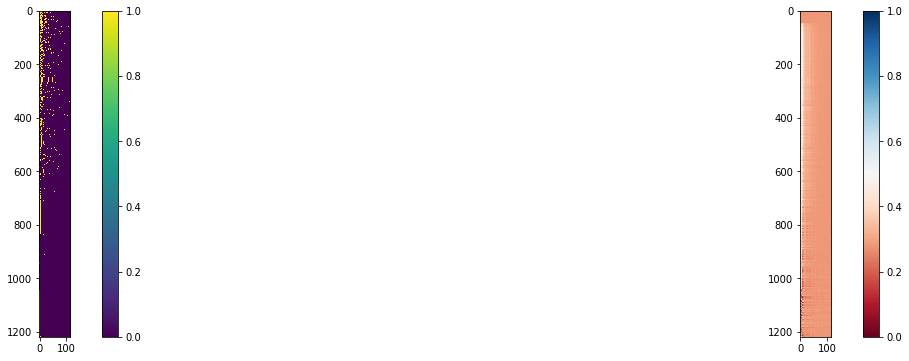

In [11]:
min_x = np.min(predict)
max_x = np.max(predict)
print(np.min(predict))
predict = predict - min_x
print(np.min(predict))

print(np.max(predict))
predict = predict / max_x
print(np.max(predict))

color_pack = 'viridis'
color_pack2 = 'RdBu'

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 6))

print(np.min(predict))
print(np.max(predict))


ax = axes[0]
im = ax.imshow(org_data, vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack))

ax = axes[1]
im2 = ax.imshow(predict, vmin=np.min(predict), vmax=np.max(predict), cmap=plt.cm.get_cmap(color_pack2))

#     ax = axes[2]
#     im = ax.imshow(predict - org_data, vmin=-1, vmax=1, cmap=plt.cm.get_cmap(color_pack))

# fig.colorbar(im, ax=axes.ravel().tolist())
#     cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
cax,kw = mpl.colorbar.make_axes([axes[0]])
cax2,kw2 = mpl.colorbar.make_axes([axes[1]])
cba = plt.colorbar(im, cax=cax, **kw)
cbb = plt.colorbar(im2, cax=cax2, **kw2)

numOfExperiment = 13
path = '/home/lpodgorsek/mag/Experiments/Results/13/dicty/'
plt.savefig(path + 'experiment' + str(numOfExperiment) + '_' + str(i) + '_org_vs_predict.png')

plt.show()

In [6]:
from base2 import load_dicty, load_pharma
graph1 = load_dicty('clustering')
# graph2 = load_pharma()

0.0
1.0

0.0
1.0

0.0
1.0
-------------RelationGraph-------------
Gene	1219
3	ann-(1219, 116), expr-(1219, 282), ppi-(1219, 1219)
0	
GO term	116
0	
1	ann-(1219, 116)
Experimental condition	282
0	
1	expr-(1219, 282)



In [24]:
from tensorflow.keras.layers import Input, Dense, Layer, Reshape, UpSampling2D, Flatten, Masking, Dropout, concatenate, Conv2D, MaxPooling2D, BatchNormalization, Lambda
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow import set_random_seed
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from sklearn.metrics import mean_squared_error


def data_generator(filenames, n_pack):
    # n_pack => 100 samples of matrix
    # n_pack = batch_size
    
    files = []              # different files
    num_packs = []          # subpacked inside of file
    for filename in filenames:
        f = np.load(filename)
        files.append(f)
        num_packs.append(f.files)
    
    counter = 0
    while True:
        x = []
        for i in range(len(files)):
            rand_num = np.random.randint(len(num_packs[i]))
            f = files[i]
            pack = num_packs[i]
            data = f[pack[rand_num]] 

            new_data = top_N_rows(data)
            x.append(new_data)
            
#             x.append(f[pack[rand_num]])
            
        yield (x, x)
        
        if counter >= n_pack:
            counter = 0
            
def top_N_rows(data, rows=100):
    _, row, col, _ = data.shape
    rows = row
    remove_col = col % 6
    data = data.reshape(row, col)
    new_data = data[:rows, :(col - remove_col)]
    return new_data.reshape(1, rows, col - remove_col, 1)
    
    
def shuffle_data(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
        np.random.shuffle(tmp_data)  # shuffle org data
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data


def replace_and_shuffle_data_with_random(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
        tmp_data[tmp_data > 0] = 1;   # set nonzero values to 1
        tmp_data = tmp_data * np.random.rand(len(tmp_data))  # multiply with random vecotor
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data

    
def order_inputs(model, org_data):
    new_order_data = []
    for inp in model.inputs:
        _, x, y, _ = inp.shape
        for data in org_data:
            _, row, col, _ = data.shape
            if x == row and y == col:
                new_order_data.append(np.array(data).reshape(1,row,col,1))
                break

    return new_order_data
            
    
class MultiModal:
    
    def __init__(self, graph=None, path=''):
        self.input_visibles = []
        self.input_layers = []
        self.outputs_layers = []
        self.input_data_size = []
        self.filenames = []
        self.inputs = None
        self.model = None
        self.path = path
        self.org_data = []
        self.predict_data = []
        self.base_line = []
        self.shuffled_data = []
        
        if graph is not None:
            self._read_graph(graph)
        self._callbacks()
                    
    def _read_graph(self, graph):
        already = set()
        for obj in graph.objects.values():        
            for relation in obj.relation_x:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)

            for relation in obj.relation_y:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)
                        
    def _set_params(self, relation):
        print(relation.name + '\t' + str(relation.matrix.shape))
        
        row, col = relation.matrix.shape
        data = np.array(relation.matrix).reshape(1,row,col,1)
        new_data = top_N_rows(data)
#         new_data = data
        _, new_r, new_c, _ = new_data.shape
        self.org_data.append(new_data)
        self.input_data_size.append((new_r, new_c))
        self._input_layer((new_r, new_c))
        self.filenames.append(self.path + relation.name + '.npz')
        
    def _input_layer(self, input_size):
        row, col = input_size
        visible = Input(shape=(row, col, 1))
#         Conv2D filtered by columns
        layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(visible)
        layer1 = MaxPooling2D((2, 2))(layer1)
        layer1 = Conv2D(32, (3, 3), activation='relu', padding='same')(layer1)
        layer1 = MaxPooling2D((2, 2))(layer1)
        layer1 = Conv2D(1, (1, 1), activation='relu', padding='same')(layer1)
        layer1 = Flatten()(layer1)

#         Conv2D filtered by rows
        layer2 = Conv2D(64, (3, 3), activation='relu', padding='same')(visible)
        layer2 = MaxPooling2D((2, 2))(layer2)
        layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(layer2)
        layer2 = MaxPooling2D((2, 2))(layer2)
        layer2 = Conv2D(1, (1, 1), activation='relu', padding='same')(layer2)
        layer2 = Flatten()(layer2)
        
        layer = concatenate([layer1, layer2])
        layer = Dense(int((row + col) / 2), activation='relu')(layer)
                
        layer = Flatten()(layer)
        layer = Dense(1000, activation="relu")(layer)
        layer = Dense(100, activation="relu")(layer)
        layer = Dense(20, activation="relu")(layer) 
        
        self.input_layers.append(layer)
        self.input_visibles.append(visible)
    
    def _output_layer(self, input_size):
        row, col = input_size

        layer = Dense(row * 5, activation='relu')(self.inputs)
        layer = Reshape((row, 1, 5))(layer)
        layer = UpSampling2D((1, int(col/6)))(layer)
        layer = Conv2D(10, (3, 3), activation='relu', padding='same')(layer)
        layer = UpSampling2D((1, 3))(layer)
        layer = Conv2D(20, (3, 3), activation='relu', padding='same')(layer)
        layer = UpSampling2D((1, 2))(layer)
        layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(layer)

        self.outputs_layers.append(layer)
        
    def _decoder(self):
        x = Dense(100, activation="relu")(self.inputs)
        x = Dense(1000, activation="relu")(x)
        self.inputs = x
        
    def _callbacks(self):
        log_dir = '/data/logs/'
        self.callbacks = [
            TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True),
            EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto')
        ]
        
    def build_model(self, optimizer='sgd', loss='mse'):
        self.inputs = concatenate(self.input_layers)
        self.inputs = Dense(20, activation="relu")(self.inputs) 
        self._decoder()

        [self._output_layer(data_size) for data_size in self.input_data_size]
        
        self.model = Model(inputs=self.input_visibles, outputs=self.outputs_layers)
        self.model.compile(optimizer=optimizer, loss=loss)
        self.model.summary()
        
    def fit(self, batch_size, epochs):
        self.batch_size = batch_size;
        self.model.fit_generator(
            data_generator(self.filenames, batch_size), 
            steps_per_epoch=batch_size, 
            epochs=epochs,
            callbacks=self.callbacks
        )
        
    def save(self, path, version):
        self.model.save(path + 'experiment_' + version + '.h5')

    def load_model(self, path, version):
        self.model = load_model(path + 'experiment_' + version + '.h5')
        
    def predict(self, random=False):
        self.org_data = order_inputs(self.model, self.org_data)
            
        if random == True:
            self.shuffled_data = replace_and_shuffle_data_with_random(self.org_data)
        else: 
            self.shuffled_data = shuffle_data(self.org_data)
            
        self.predict_data = self.model.predict(self.org_data)
        self.base_line = self.model.predict(self.shuffled_data)
        outputHeader = 'Data\t\t'
        outputHeader += 'Density\t\t'
        outputHeader += 'Predict\t\t'
        outputHeader += 'BaseLine\t'
        outputHeader += 'AVG Mean\t'
        outputHeader += 'Predict (mean)\t'
        outputHeader += 'Predict (min)\t'
        outputHeader += 'Predict (max)\t'
        print(outputHeader)
        
#         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
        for i in range(len(self.org_data)):
            _, row, col, _ = self.org_data[i].shape 
            mse = mean_squared_error(self.org_data[i].flatten(), self.predict_data[i].flatten())
            mse_base_line = mean_squared_error(self.shuffled_data[i].flatten(), self.base_line[i].flatten())
            
            non_zeros = self.org_data[i].flatten()
            non_zeros[self.org_data[i].flatten() > 0] = 1
            org_mean = round(np.mean(non_zeros * self.org_data[i].flatten()), 5)
            predict_mean = round(np.mean(non_zeros * self.predict_data[i].flatten()), 5)
            
            outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
            outputBody += str(round((np.count_nonzero(self.org_data[i])/(row * col)) * 100, 2)) + '% \t\t'
            outputBody += str(round(mse * 100, 5)) + '% \t'
            outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
            outputBody += str(org_mean) + '\t\t'
            outputBody += str(predict_mean) + '\t\t'
            outputBody += str(round(min(self.predict_data[i].flatten()), 5)) + '\t\t'
            outputBody += str(round(max(self.predict_data[i].flatten()), 5)) + '\t'
            print(outputBody)
            
       

In [26]:
if 'model1' in locals():
    del model1
    
path_data = '/data/samples/multiple_inputs_clustering/dicty/'
numOfExperiment = 12
    
model1 = MultiModal(graph=graph1, path=path_data)
model1.load_model('/data/multimodal/dicty/', str(numOfExperiment))
model1.predict(random=False)

expr	(1219, 282)
ann	(1219, 116)
ppi	(1219, 1219)
Data		Density		Predict		BaseLine	AVG Mean	Predict (mean)	Predict (min)	Predict (max)	
(1219,114) 	5.43% 		4.99615% 	5.17952% 	0.05432		0.00311		0.03554		0.25553	
(1219,282) 	95.19% 		9.75385% 	9.73956% 	0.82182		0.54335		0.51414		0.58255	
(1219,1218) 	3.09% 		2.10956% 	2.11079% 	0.02482		0.00052		0.01512		0.18957	


0.035544228
0.2555291

-1.1042989708099116
1.4655405968519708


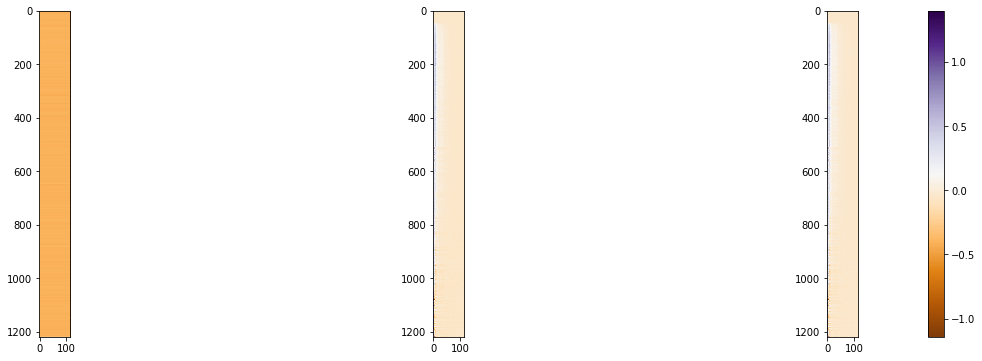

In [55]:
i = 0
color_pack = 'PuOr'

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 6))
_, row, col, _ = model1.org_data[i].shape
org_data = np.c_[model1.org_data[i].reshape((row, col)), np.empty((row, 2))]
predict_NN = np.c_[model1.predict_data[i].reshape((row, col)), np.empty((row, 2))]

print(np.min(model1.predict_data[i]))
print(np.max(model1.predict_data[i]))
print()
print(np.min(predict_DFMF))
print(np.max(predict_DFMF))

ax = axes[0]
im = ax.imshow(predict_NN, vmin=np.min(predict_NN), vmax=np.max(predict_NN), cmap=plt.cm.get_cmap(color_pack))
ax = axes[1]
im = ax.imshow(predict_DFMF, vmin=np.min(predict_DFMF), vmax=np.max(predict_DFMF), cmap=plt.cm.get_cmap(color_pack))
ax = axes[2]
im = ax.imshow(predict_DFMF-predict_NN, vmin=np.min(predict_DFMF-predict_NN), vmax=np.max(predict_DFMF-predict_NN), cmap=plt.cm.get_cmap(color_pack))

cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
# cax,kw = mpl.colorbar.make_axes([axes[0]])
# cax2,kw2 = mpl.colorbar.make_axes([axes[1]])
cba = plt.colorbar(im, cax=cax, **kw)
# cbb = plt.colorbar(im2, cax=cax2, **kw2)

plt.savefig('/mag/Experiments/Results/13/dicty/experiment_' + str(i) + '_pred_NN_vs_pred_DFMF_and_intersection.png')

plt.show()

0.035544228
0.2555291

-1.1042989708099116
1.4655405968519708


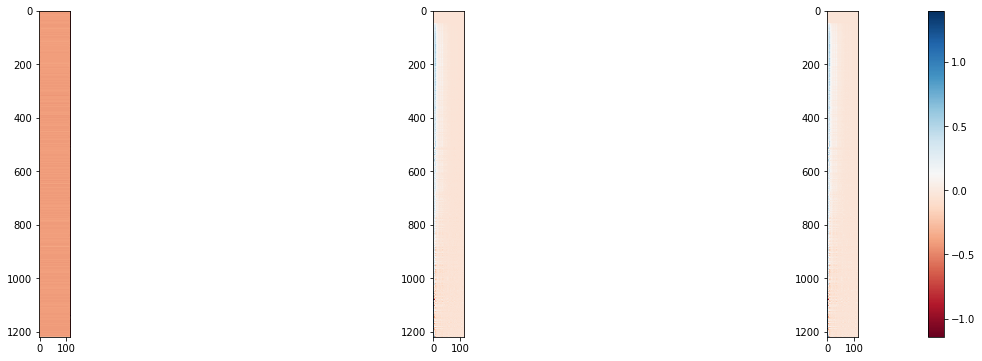

In [59]:
i = 0
color_pack = 'RdBu'

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 6))

_, row, col, _ = model1.org_data[i].shape
corr_coef_NN = np.c_[np.corrcoef(model1.org_data[i].reshape((row, col))), np.empty((row, 2))]
corr_coef_DFMF = np.corrcoef(predict_DFMF)


# org_data = np.c_[model1.org_data[i].reshape((row, col)), np.empty((row, 2))]
# predict_NN = np.c_[model1.predict_data[i].reshape((row, col)), np.empty((row, 2))]

print(np.min(model1.predict_data[i]))
print(np.max(model1.predict_data[i]))
print()
print(np.min(predict_DFMF))
print(np.max(predict_DFMF))

ax = axes[0]
im = ax.imshow(predict_NN, vmin=np.min(predict_NN), vmax=np.max(predict_NN), cmap=plt.cm.get_cmap(color_pack))
ax = axes[1]
im = ax.imshow(predict_DFMF, vmin=np.min(predict_DFMF), vmax=np.max(predict_DFMF), cmap=plt.cm.get_cmap(color_pack))
ax = axes[2]
im = ax.imshow(predict_DFMF-predict_NN, vmin=np.min(predict_DFMF-predict_NN), vmax=np.max(predict_DFMF-predict_NN), cmap=plt.cm.get_cmap(color_pack))

cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
# cax,kw = mpl.colorbar.make_axes([axes[0]])
# cax2,kw2 = mpl.colorbar.make_axes([axes[1]])
cba = plt.colorbar(im, cax=cax, **kw)
# cbb = plt.colorbar(im2, cax=cax2, **kw2)

plt.savefig('/mag/Experiments/Results/13/dicty/experiment_' + str(i) + '_corr_coef_by_row(NN, DFMF).png')

plt.show()